In [48]:
using Gen,PyPlot,Statistics, StatsPlots

In [115]:
# Choose to eat at the Italian or French restaurants
actions = ["italian", "french"]
states = ["pizza","steak frites"]
PIZZA = 1
STEAK_FRITES = 2
function transition(state,action)
    if action == "italian"
        return PIZZA
    else
        return STEAK_FRITES
    end
end

function utility(state)
    if state == PIZZA
        return 10
    else
        return 0
    end
end;

In [116]:
function max_agent(state)
    return argmax(action -> utility(transition(state,action)),actions)
end;

In [117]:
max_action = max_agent(:initial_state)
print("choice in initial state: $max_action");

choice in initial state: italian

In [118]:
@gen function heads()
    a = @trace(bernoulli(0.5), :a)
    b = @trace(bernoulli(0.5), :b)
    c = @trace(bernoulli(0.5), :c)
    @trace(normal(a + b + c, 0.01), :sum)
end

function infer_heads(sum,amount_of_computation)
    observations = Gen.choicemap()
    observations[:sum] = sum
    trace, = Gen.generate(heads,(),observations)
    as = []
    for i = 1:1000
        trace, = Gen.mh(trace, select(:a, :b, :c))
        push!(as, trace[:a])
    end
    return as
end;


0.643


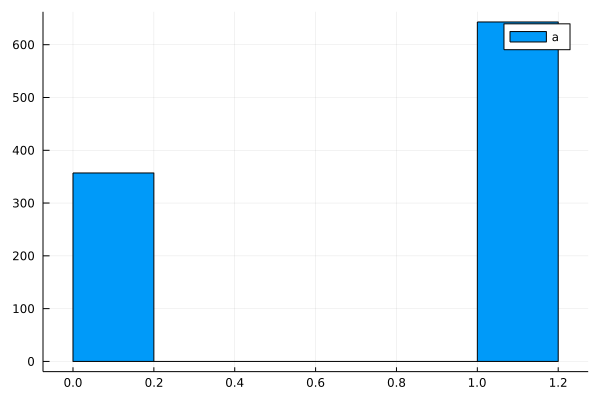

In [119]:
as = infer_heads(2,1000)
println(mean(as));
histogram(as, label="a")


In [120]:
@gen function inference_agent(state)
    action_index = @trace(uniform_discrete(1,length(actions)),:action_index)
    @trace(normal(transition(state,actions[action_index]), 0.01), :state)
end;
function infer_inference_agent(state)
    observations = Gen.choicemap()
    observations[:state] = state
    trace, = Gen.generate(inference_agent,(:initial_state,),observations)
    action_indices = []
    for i = 1:1000
        trace, = Gen.mh(trace, select(:action_index))
        push!(action_indices, trace[:action_index])
    end
    return action_indices
end;

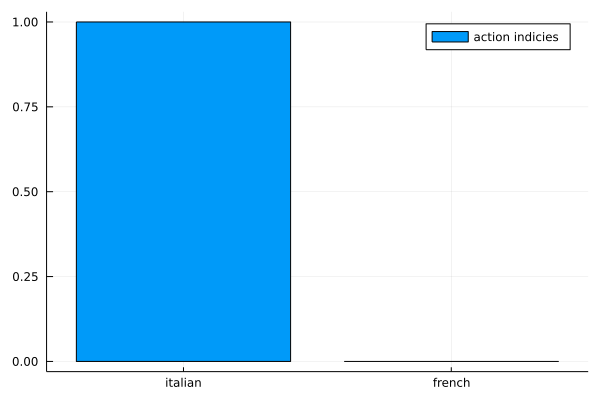

In [128]:
action_indices = infer_inference_agent(PIZZA)
occurences=Dict([(action,count(x->actions[x]==action,action_indices)) for action in actions])
StatsPlots.bar(actions,[occurences["italian"]/1000,occurences["french"]/1000],label="action indicies")

In [ ]:
,